# Deep Learning Methods for Medical Image Analysis (CM2003)

# Laboratory Assignment 5: Part 3: K-fold Cross Validation

Lab Group 8:
- Gnana Spandana Akumalla
- Patrik Svensson
- Serkan Arda Yilal

In [1]:
# Import the required libraries
import os
import tensorflow as tf
import numpy as np
import cv2
import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D, Activation, BatchNormalization, Input
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, Conv2D, Conv2DTranspose, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall
import matplotlib.pyplot as plt
from Utils import loss_dice_plot, loss_accuracy_plot, load_data, load_partial_data, load_image, load_mask, create_generator, image_mask_generator, dice_coef
from Utils import dice_coef_loss, train_unet
from Models import conv_block, get_unet


### Preparing required functions

In [2]:
def fold_prepare(images_array, masks_array, k = 3):
    images_folds = []
    masks_folds = []
    fold_size = images_array.shape[0]//k
    #Separating the images and masks into folds
    for fold in range(k):
        images_folds.append(images_array[(fold*fold_size):( (fold + 1)*fold_size )])
        masks_folds.append(masks_array[(fold*fold_size):( (fold + 1)*fold_size )])
        
    return images_folds, masks_folds

def train_val_fold_split(images_folds, masks_folds, fold):
    #copying the image and mask folds not to affect the original lists
    images_folds_copy = images_folds.copy()
    masks_folds_copy = masks_folds.copy()
    
    #choosing the vaidation images and masks
    x_val = images_folds_copy[fold]
    y_val = masks_folds_copy[fold]
    
    #removing the validation images and masks from the list to use the remaining as training folds
    del images_folds_copy[fold]
    del masks_folds_copy[fold]
    
    x_train = np.array(images_folds_copy)
    x_train = x_train.reshape(x_train.shape[0]*x_train.shape[1], x_train.shape[2], x_train.shape[3])
    
    y_train = np.array(masks_folds_copy)
    y_train = y_train.reshape(y_train.shape[0]*y_train.shape[1], y_train.shape[2], y_train.shape[3])
    
    # Ensure that the shape of the data matches the model's input shape
    x_train = x_train.reshape((-1, img_width, img_height, 1))
    y_train = y_train.reshape((-1, img_width, img_height, 1))
    x_val = x_val.reshape((-1, img_width, img_height, 1))
    y_val = y_val.reshape((-1, img_width, img_height, 1))
    
    return x_train, y_train, x_val, y_val

def binarize_mask(data_dir, img_height, img_width, val_lower=0.5, val_upper=1):
    data_dir_copy = data_dir.copy()  # Create a copy of the input data
    data_dir_copy[data_dir_copy > val_upper] = 0
    data_dir_copy[(data_dir_copy >= val_lower) & (data_dir_copy <= val_upper)] = 2
    data_dir_copy[data_dir_copy < val_lower] = 1
    return data_dir_copy

def multi_organ_loss(y_true, y_pred):
    loss_left = tf.keras.losses.binary_crossentropy(y_true[0], y_pred[0])
    loss_right = tf.keras.losses.binary_crossentropy(y_true[1], y_pred[1])

    # Combine the left and right lung loss (you can use any combination, e.g., sum, mean, etc.)
    combined_loss = loss_left + loss_right

    return combined_loss

In [14]:
def loss_metric_plot(clf_hist, string):

#Function for plotting the results of loss and dice coefficient

#------INPUTS------
#clf_hist = classifier history during training.
#string = title for the plot.

                
    fig, axs = plt.subplots(2, 2, figsize=(10, 12))

    #Plot for loss values
    axs[0,0].set_title("Learning curve")
    axs[0,0].plot(clf_hist.history["loss"], label="loss")
    axs[0,0].plot(clf_hist.history["val_loss"], label="val_loss")
    axs[0,0].plot( np.argmin(clf_hist.history["val_loss"]),
                    np.min(clf_hist.history["val_loss"]),
                    marker="x", color="r", label="best model")

    axs[0,0].set_xlabel("Epochs")
    axs[0,0].set_ylabel("Loss Value")
    axs[0,0].legend()

    fig.suptitle(string, fontsize=13)

    #Plot for dice values
    axs[0,1].set_title("Learning curve")
    axs[0,1].plot(clf_hist.history["dice_coef"], label="dice_coefficient")
    axs[0,1].plot(clf_hist.history["val_dice_coef"], label="val_dice_coefficient")
    axs[0,1].plot( np.argmax(clf_hist.history["val_dice_coef"]),
                    np.max(clf_hist.history["val_dice_coef"]),
                    marker="x", color="r", label="best model")

    axs[0,1].set_xlabel("Epochs")
    axs[0,1].set_ylabel("Dice Coefficient")
    axs[0,1].legend()

    
    #Plot for precision values
    axs[1,0].set_title("Learning curve")
    axs[1,0].plot(clf_hist.history["precision"], label="precision")
    axs[1,0].plot(clf_hist.history["val_precision"], label="val_precision")
    axs[1,0].plot( np.argmax(clf_hist.history["val_precision"]),
                    np.max(clf_hist.history["val_precision"]),
                    marker="x", color="r", label="best model")

    axs[1,0].set_xlabel("Epochs")
    axs[1,0].set_ylabel("Precision")
    axs[1,0].legend()

    
    #Plot for recall values
    axs[1,1].set_title("Learning curve")
    axs[1,1].plot(clf_hist.history["recall"], label="recall")
    axs[1,1].plot(clf_hist.history["val_recall"], label="val_recall")
    axs[1,1].plot( np.argmax(clf_hist.history["val_recall"]),
                    np.max(clf_hist.history["val_recall"]),
                    marker="x", color="r", label="best model")

    axs[1,1].set_xlabel("Epochs")
    axs[1,1].set_ylabel("Recall")
    axs[1,1].legend()
    plt.show()

### Preparing data and setting variables

In [4]:
# Paths 
data_dir = 'Data/DL_course/Lab3/CT/'
image_dir = os.path.join(data_dir, 'Image/')
mask_dir = os.path.join(data_dir, 'Mask/')
img_width, img_height= 240, 240

# Load and preprocess images and masks. Only part of the dataset should be loaded because the kernel crashes otherwise
 # How many images to be loaded (dataset has >8000 images)
images, masks = load_partial_data(data_dir, image_dir, mask_dir, img_width, img_height, number_of_images=1000)


load_partial_data: Printout to see that the images and labels are matched:
Data/DL_course/Lab3/CT/Image/Im0_64.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_64_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_65.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_65_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_66.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_66_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_67.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_67_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_68.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_68_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_69.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_69_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_70.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_70_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_71.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_71_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_72.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_72_Mask.png
Data/DL_course/Lab3/CT/Image/Im0_73.png 	 --- 	  Data/DL_course/Lab3/CT/Mask/Im0_73_Mask

In [5]:
images_array = np.array(images)
masks_array = np.array(masks)

In [6]:
k = 3
images_folds, masks_folds = fold_prepare(images_array, masks_array, k)

In [7]:
# Define Constants and Paths

base= 8
learning_rate = 0.0001
dropout = 0.2
batch_size = 8
metrics = [dice_coef, Precision(), Recall()] #Only dice_coef for task 1a 
batchnorm = True

verbose = 1
generator = None

loss =[dice_coef_loss] 

## Cross Validation for left lung

In this part, we experimented cross validation for classification of left lung.

Time to binarize with dataset of 666 images: 0.02 minutes
Epoch 1/150
84/84 [==============================] - 7s 51ms/step - loss: -0.9017 - dice_coef: 0.9019 - precision: 1.0000 - recall: 0.7108 - val_loss: -0.7082 - val_dice_coef: 0.7084 - val_precision: 1.0000 - val_recall: 0.6381
Epoch 2/150
84/84 [==============================] - 3s 39ms/step - loss: -0.9339 - dice_coef: 0.9341 - precision: 1.0000 - recall: 0.9693 - val_loss: -0.8108 - val_dice_coef: 0.8110 - val_precision: 1.0000 - val_recall: 0.9904
Epoch 3/150
84/84 [==============================] - 3s 39ms/step - loss: -0.9530 - dice_coef: 0.9531 - precision: 1.0000 - recall: 0.9807 - val_loss: -0.8936 - val_dice_coef: 0.8938 - val_precision: 1.0000 - val_recall: 0.9974
Epoch 4/150
84/84 [==============================] - 3s 39ms/step - loss: -0.9673 - dice_coef: 0.9674 - precision: 1.0000 - recall: 0.9893 - val_loss: -0.9011 - val_dice_coef: 0.9012 - val_precision: 1.0000 - val_recall: 0.9971
Epoch 5/150
84/84 [===========

Epoch 72/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0644 - dice_coef: 1.0642 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0575 - val_dice_coef: 1.0577 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 73/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0645 - dice_coef: 1.0647 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0576 - val_dice_coef: 1.0578 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 74/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0646 - dice_coef: 1.0644 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0577 - val_dice_coef: 1.0580 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 75/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0647 - dice_coef: 1.0646 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0578 - val_dice_coef: 1.0581 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 76/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0648 -

Epoch 108/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0664 - dice_coef: 1.0664 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0598 - val_dice_coef: 1.0601 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 109/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0664 - dice_coef: 1.0665 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0598 - val_dice_coef: 1.0601 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 110/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0664 - dice_coef: 1.0663 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0599 - val_dice_coef: 1.0601 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 111/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0664 - dice_coef: 1.0663 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0599 - val_dice_coef: 1.0602 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 112/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0

Epoch 144/150
84/84 [==============================] - 3s 38ms/step - loss: -1.0668 - dice_coef: 1.0666 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0603 - val_dice_coef: 1.0605 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 145/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0668 - dice_coef: 1.0668 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0603 - val_dice_coef: 1.0605 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 146/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0668 - dice_coef: 1.0666 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0603 - val_dice_coef: 1.0605 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 147/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0668 - dice_coef: 1.0670 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0603 - val_dice_coef: 1.0605 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 148/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0

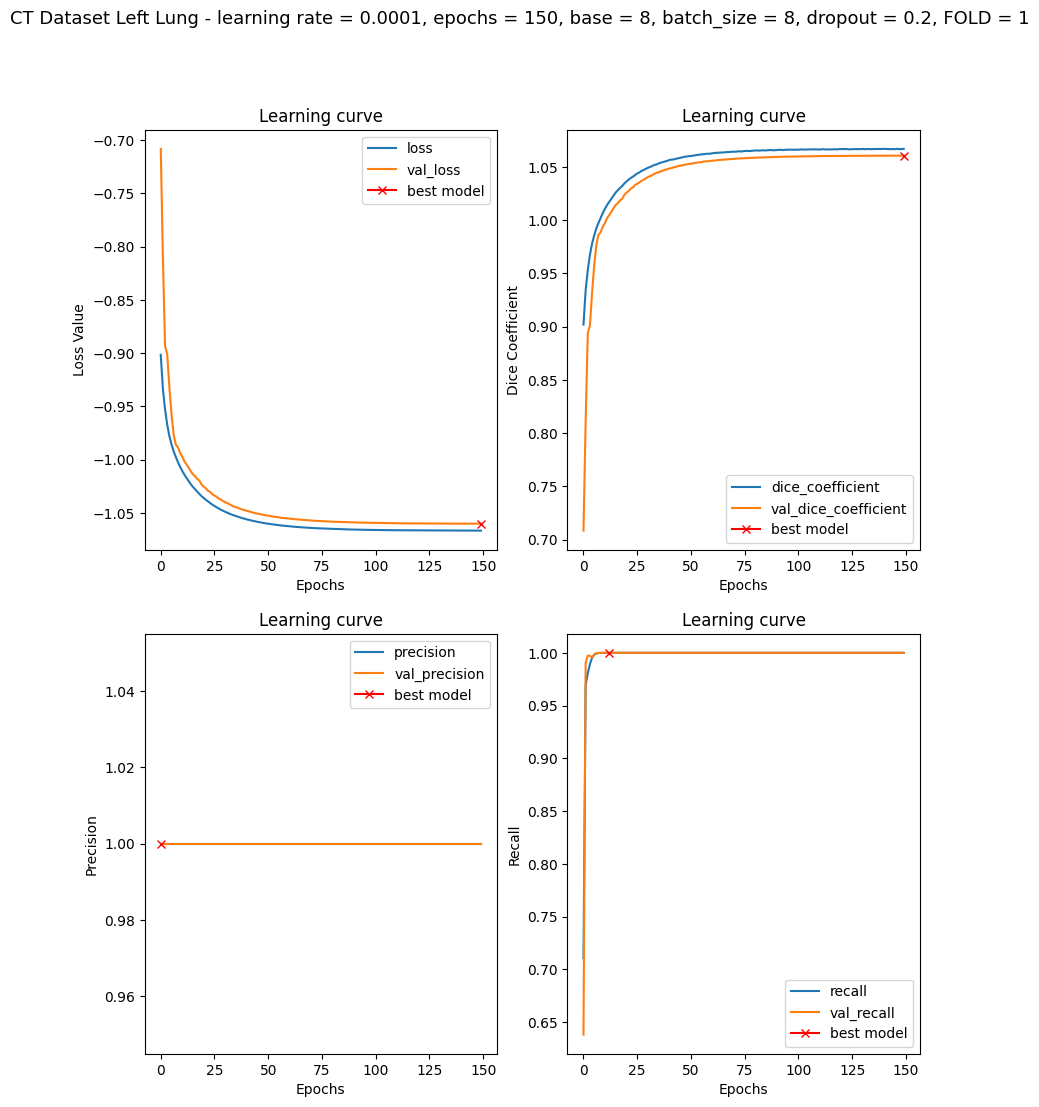

Time to binarize with dataset of 666 images: 0.02 minutes
Epoch 1/150
84/84 [==============================] - 8s 52ms/step - loss: -0.8586 - dice_coef: 0.8588 - precision: 1.0000 - recall: 0.9865 - val_loss: -0.7848 - val_dice_coef: 0.7848 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 2/150
84/84 [==============================] - 3s 39ms/step - loss: -0.8852 - dice_coef: 0.8853 - precision: 1.0000 - recall: 0.9857 - val_loss: -0.8605 - val_dice_coef: 0.8605 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/150
84/84 [==============================] - 3s 39ms/step - loss: -0.8998 - dice_coef: 0.8999 - precision: 1.0000 - recall: 0.9859 - val_loss: -0.9111 - val_dice_coef: 0.9111 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/150
84/84 [==============================] - 3s 39ms/step - loss: -0.9124 - dice_coef: 0.9125 - precision: 1.0000 - recall: 0.9881 - val_loss: -0.9437 - val_dice_coef: 0.9437 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/150
84/84 [===========

Epoch 72/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0566 - dice_coef: 1.0566 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0675 - val_dice_coef: 1.0676 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 73/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0568 - dice_coef: 1.0566 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0678 - val_dice_coef: 1.0678 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 74/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0570 - dice_coef: 1.0569 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0679 - val_dice_coef: 1.0679 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 75/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0571 - dice_coef: 1.0570 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0681 - val_dice_coef: 1.0681 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 76/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0573 -

Epoch 108/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0602 - dice_coef: 1.0602 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0711 - val_dice_coef: 1.0711 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 109/150
84/84 [==============================] - 3s 40ms/step - loss: -1.0602 - dice_coef: 1.0602 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0711 - val_dice_coef: 1.0711 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 110/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0603 - dice_coef: 1.0603 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0711 - val_dice_coef: 1.0711 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 111/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0603 - dice_coef: 1.0603 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0712 - val_dice_coef: 1.0712 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 112/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0

Epoch 144/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0609 - dice_coef: 1.0609 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0718 - val_dice_coef: 1.0718 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 145/150
84/84 [==============================] - 3s 40ms/step - loss: -1.0609 - dice_coef: 1.0609 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0718 - val_dice_coef: 1.0718 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 146/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0609 - dice_coef: 1.0608 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0718 - val_dice_coef: 1.0718 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 147/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0609 - dice_coef: 1.0610 - precision: 1.0000 - recall: 1.0000 - val_loss: -1.0718 - val_dice_coef: 1.0718 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 148/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0

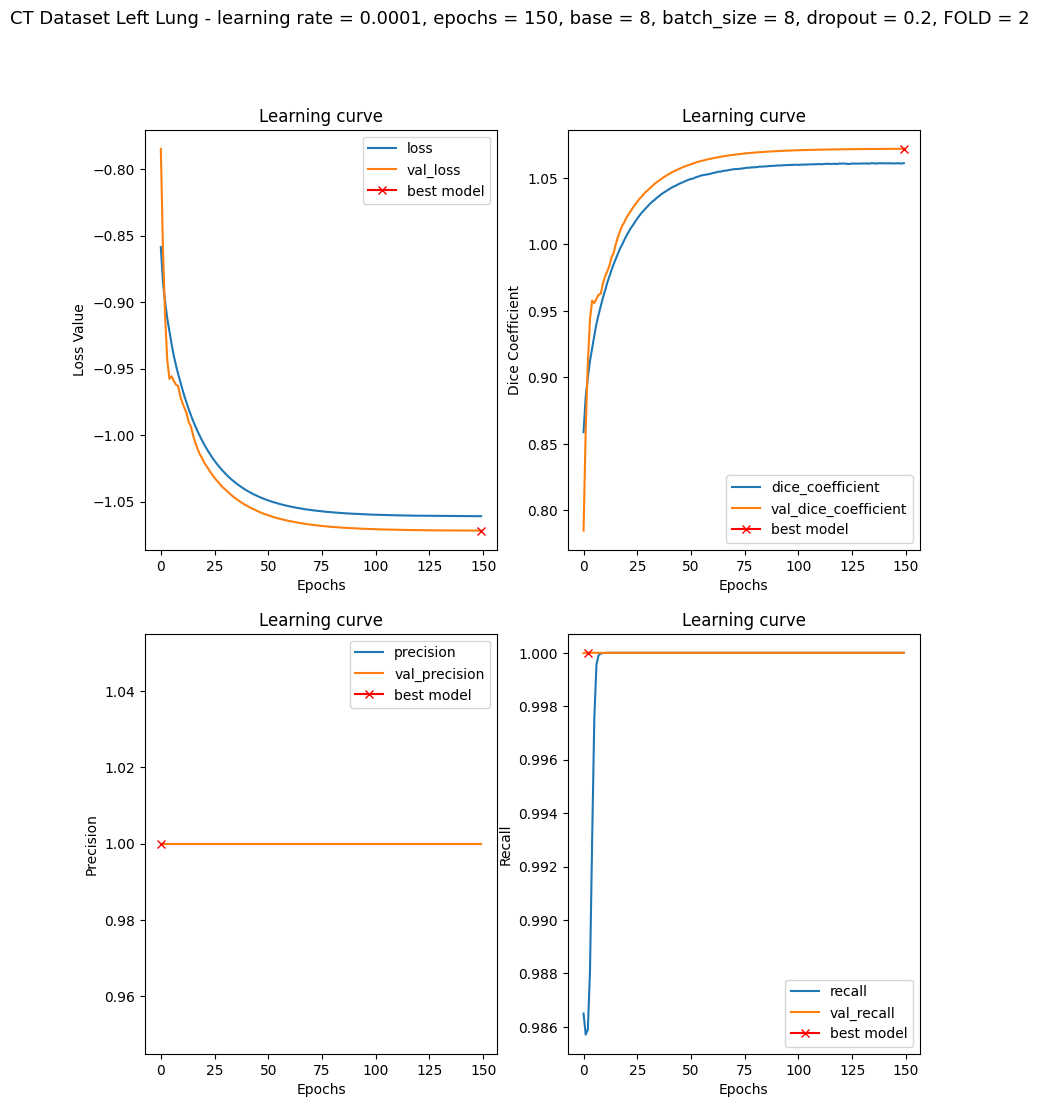

Time to binarize with dataset of 666 images: 0.02 minutes
Epoch 1/150
84/84 [==============================] - 8s 52ms/step - loss: -0.5346 - dice_coef: 0.5353 - precision: 1.0000 - recall: 0.4939 - val_loss: -0.6872 - val_dice_coef: 0.6871 - val_precision: 1.0000 - val_recall: 0.2600
Epoch 2/150
84/84 [==============================] - 3s 39ms/step - loss: -0.6468 - dice_coef: 0.6471 - precision: 1.0000 - recall: 0.6023 - val_loss: -0.7460 - val_dice_coef: 0.7459 - val_precision: 1.0000 - val_recall: 0.9962
Epoch 3/150
84/84 [==============================] - 3s 39ms/step - loss: -0.6880 - dice_coef: 0.6881 - precision: 1.0000 - recall: 0.7307 - val_loss: -0.7711 - val_dice_coef: 0.7710 - val_precision: 1.0000 - val_recall: 0.9962
Epoch 4/150
84/84 [==============================] - 3s 39ms/step - loss: -0.7274 - dice_coef: 0.7277 - precision: 1.0000 - recall: 0.7107 - val_loss: -0.7687 - val_dice_coef: 0.7686 - val_precision: 1.0000 - val_recall: 0.9624
Epoch 5/150
84/84 [===========

Epoch 72/150
84/84 [==============================] - 3s 39ms/step - loss: -0.9843 - dice_coef: 0.9845 - precision: 1.0000 - recall: 0.9994 - val_loss: -0.9949 - val_dice_coef: 0.9948 - val_precision: 1.0000 - val_recall: 0.9991
Epoch 73/150
84/84 [==============================] - 3s 39ms/step - loss: -0.9858 - dice_coef: 0.9858 - precision: 1.0000 - recall: 0.9994 - val_loss: -0.9955 - val_dice_coef: 0.9954 - val_precision: 1.0000 - val_recall: 0.9987
Epoch 74/150
84/84 [==============================] - 3s 39ms/step - loss: -0.9874 - dice_coef: 0.9875 - precision: 1.0000 - recall: 0.9995 - val_loss: -0.9959 - val_dice_coef: 0.9958 - val_precision: 1.0000 - val_recall: 0.9994
Epoch 75/150
84/84 [==============================] - 3s 39ms/step - loss: -0.9889 - dice_coef: 0.9891 - precision: 1.0000 - recall: 0.9994 - val_loss: -0.9989 - val_dice_coef: 0.9988 - val_precision: 1.0000 - val_recall: 0.9994
Epoch 76/150
84/84 [==============================] - 3s 39ms/step - loss: -0.9904 -

Epoch 108/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0261 - dice_coef: 1.0261 - precision: 1.0000 - recall: 0.9995 - val_loss: -1.0294 - val_dice_coef: 1.0293 - val_precision: 1.0000 - val_recall: 0.9994
Epoch 109/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0269 - dice_coef: 1.0267 - precision: 1.0000 - recall: 0.9994 - val_loss: -1.0298 - val_dice_coef: 1.0297 - val_precision: 1.0000 - val_recall: 0.9994
Epoch 110/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0278 - dice_coef: 1.0275 - precision: 1.0000 - recall: 0.9995 - val_loss: -1.0306 - val_dice_coef: 1.0305 - val_precision: 1.0000 - val_recall: 0.9996
Epoch 111/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0286 - dice_coef: 1.0286 - precision: 1.0000 - recall: 0.9995 - val_loss: -1.0311 - val_dice_coef: 1.0310 - val_precision: 1.0000 - val_recall: 0.9994
Epoch 112/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0

Epoch 144/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0478 - dice_coef: 1.0479 - precision: 1.0000 - recall: 0.9998 - val_loss: -1.0470 - val_dice_coef: 1.0469 - val_precision: 1.0000 - val_recall: 0.9998
Epoch 145/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0482 - dice_coef: 1.0482 - precision: 1.0000 - recall: 0.9998 - val_loss: -1.0472 - val_dice_coef: 1.0471 - val_precision: 1.0000 - val_recall: 0.9998
Epoch 146/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0486 - dice_coef: 1.0486 - precision: 1.0000 - recall: 0.9998 - val_loss: -1.0477 - val_dice_coef: 1.0476 - val_precision: 1.0000 - val_recall: 0.9998
Epoch 147/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0490 - dice_coef: 1.0492 - precision: 1.0000 - recall: 0.9998 - val_loss: -1.0481 - val_dice_coef: 1.0479 - val_precision: 1.0000 - val_recall: 0.9998
Epoch 148/150
84/84 [==============================] - 3s 39ms/step - loss: -1.0

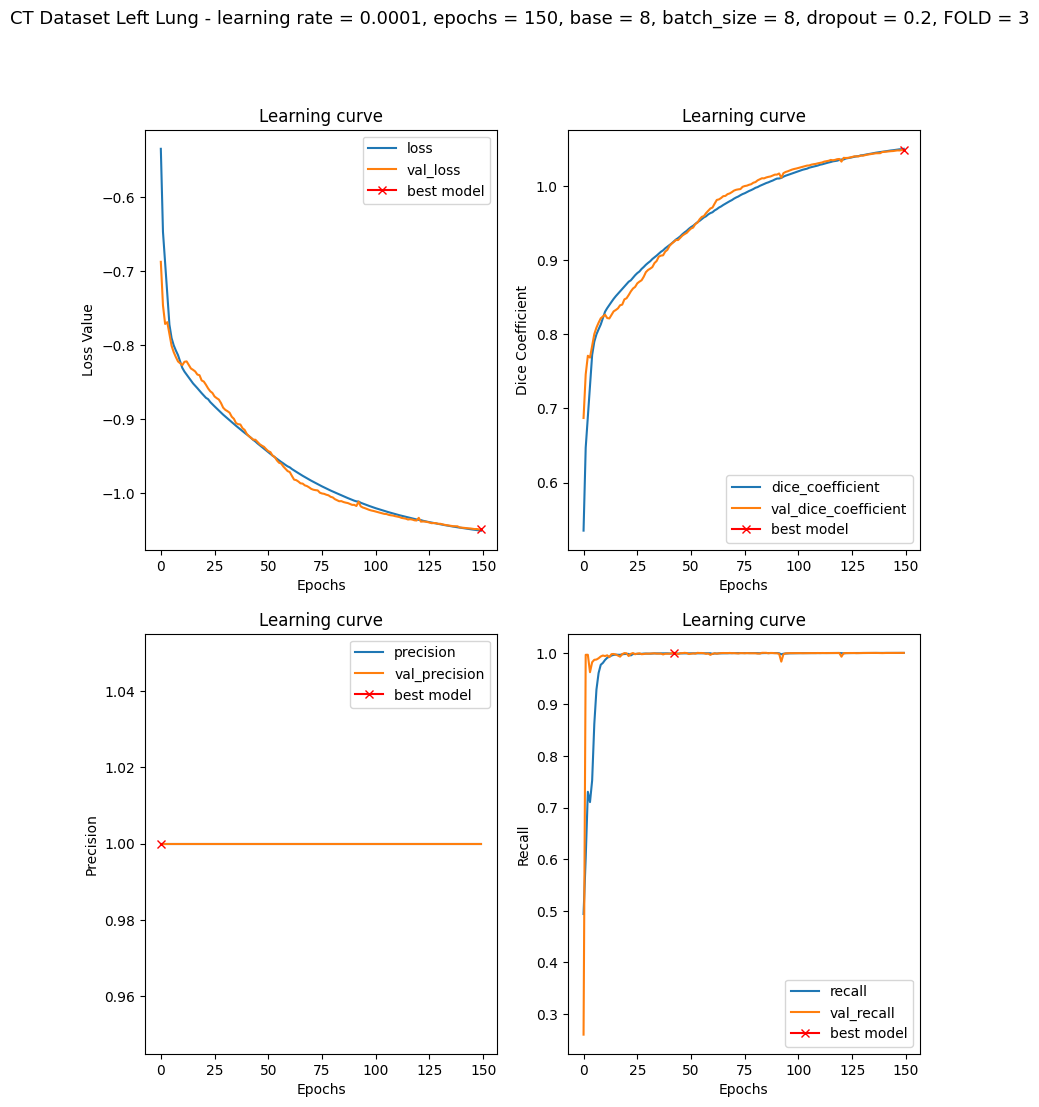

In [16]:
history_list = []
epochs = 150
for i in range(k):

    x_train, y_train, x_val, y_val = train_val_fold_split(images_folds, masks_folds, i)
    
    t0=time.time()

    #Left lung
    y_train_left=binarize_mask(y_train.copy(), img_height, img_width, val_lower=0.9, val_upper=1)
    y_val_left=binarize_mask(y_val.copy(), img_height, img_width, val_lower=0.9, val_upper=1)

    #Right lung
    y_train_right=binarize_mask(y_train.copy(), img_height, img_width, val_lower=0.5, val_upper=0.7)
    y_val_right=binarize_mask(y_val.copy(), img_height, img_width, val_lower=0.5, val_upper=0.7)

    t1=time.time()
    print("Time to binarize with dataset of", len(y_train_left),"images:", round((t1-t0)/60,2), "minutes")
    
    model = get_unet(input_shape=(img_width, img_height, 1), base = base, batchnorm=batchnorm, dropout = dropout, n_class = 2)

    model, history = train_unet(model, x_train, y_train_left, x_val, y_val_left, batch_size, epochs, learning_rate,
                   metrics, verbose = verbose,
                   loss = loss,generator = generator)
    
    history_list.append(history)
    
    loss_metric_plot(history, "CT Dataset Left Lung - learning rate = {}, epochs = {}, base = {}, batch_size = {}, dropout = {}, FOLD = {}".format(learning_rate, epochs,
                                                                                                base,batch_size, dropout,i+1))